## Семинар 7: "Методы оптимизации"

ФИО: Зеленцов Алексей Викторович

In [19]:
import numpy as np
#from sklearn.datasets import fetch_mldata
#from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline

import seaborn as sns

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [20]:
import abc

class Optimizer(abc.ABC):
    def __init__(self, list_params):
        self.params = list(list_params)

    def step(self, err):
        pass

    def finish(self):
        with torch.no_grad():
            for param in self.params:
                param.grad.data.zero_()

In [21]:
class GD(Optimizer):
    def __init__(self, list_params, learning_rate):
        super().__init__(list_params)

        self.learning_rate = learning_rate

    def step(self, err):
        loss = err()
        loss.backward()

        with torch.no_grad():
            for param in self.params:
                param -= self.learning_rate * param.grad

        self.finish() 

In [22]:
class Momentum(GD):
    def __init__(self, list_params, learning_rate, gamma=0.9):
        super().__init__(list_params, learning_rate)

        self.gamma = gamma

        self.vs = [torch.zeros_like(param) for param in self.params]

    def step(self, err):
        loss = err()
        loss.backward()

        with torch.no_grad():
            for v, param in zip(self.vs, self.params):
                v.copy_(self.gamma * v + self.learning_rate * param.grad)                
                param -= v

        self.finish()
        

In [23]:
class NAG(GD):
    def __init__(self, list_params, learning_rate, gamma=0.9):
        super().__init__(list_params, learning_rate)

        self.gamma = gamma

        self.vs = [torch.zeros_like(param) for param in self.params]

    def step(self, err):
        with torch.no_grad():
            for v, param in zip(self.vs, self.params):
                param -= self.gamma * v

        loss = err()
        loss.backward()

        with torch.no_grad():
            for v, param in zip(self.vs, self.params):
                param += self.gamma * v

                v.copy_(self.gamma * v + self.learning_rate * param.grad)        

                param -= v

        self.finish()

In [24]:
class Adagrad(GD):
    def __init__(self, list_params, learning_rate=0.01, eps=10**-8):
        super().__init__(list_params, learning_rate)

        self.g_sq_list = [torch.zeros_like(param) for param in self.params]

        self.eps = eps

    def step(self, err):
        loss = err()
        loss.backward()

        with torch.no_grad():
            for g_sq, param in zip(self.g_sq_list, self.params):
                g_sq.copy_(g_sq + param.grad**2)
                param -= self.learning_rate * param.grad / (g_sq + self.eps)**0.5

        self.finish()

In [25]:
class Adadelta(Optimizer):
    def __init__(self, list_params, gamma=0.9):
        super().__init__(list_params)

        self.gamma = gamma

        self.params_delta = torch.ones(1)
        self.params_delta *= self.gamma**2

        self.g_sq_list = [torch.zeros_like(param) for param in self.params]

        self.eps = 10**-8

    def step(self, err):
        loss = err()
        loss.backward()

        with torch.no_grad():
            delta_sum = 0
            delta_params = 0
            current_learning_rate = self.params_delta.sqrt().item()
            for g_sq, param in zip(self.g_sq_list, self.params):    
                g_sq.copy_(self.gamma * g_sq + (1 - self.gamma) * param.grad**2)


                delta = current_learning_rate * param.grad / (g_sq + self.eps)**0.5    
                param -= delta

                delta_sum += (delta**2).sum().item()
                delta_params += delta.numel()

                delta_sum /= delta_params
                self.params_delta.copy_(self.gamma * self.params_delta + (1 - self.gamma) * delta_sum)

        self.finish()

In [26]:
class Adam(GD):
    def __init__(self, list_params, learning_rate, beta1=0.9, beta2=0.999, eps=10**-8):
        super().__init__(list_params, learning_rate)

        self.beta1 = beta1
        self.beta2 = beta2

        self.g_sq_list = [torch.zeros_like(param) for param in self.params]
        
        self.ms = [torch.zeros_like(param) for param in self.params]
        self.vs = [torch.zeros_like(param) for param in self.params]

        self.eps = eps
    
    def step(self, err):
        loss = err()
        loss.backward()
        
        with torch.no_grad():
            t = 0
            for v, m, param in zip(self.vs, self.ms, self.params):
                t += 1
                m.copy_(self.beta1 * m + (1 - self.beta1) * param.grad)

                v.copy_(self.beta2 * v + (1 - self.beta2) * (param.grad ** 2))
                
                m_roof = m / (1 - (self.beta1 ** t))
                
                v_roof = v / (1 - (self.beta2 ** t))

                param -= self.learning_rate * m / (v**0.5 + self.eps)

        self.finish()

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [31]:
def make_var(x):
    x = np.array([float(x)])
    x = torch.from_numpy(x)
    return torch.autograd.Variable(x, requires_grad=True)

x, y = make_var(1), make_var(2)

In [99]:
from functools import partial
def use_optimizers(J, true_minimum=None, learning_rate=0.01, max_iter=1000000):
    
    optimizers = [
        GD([x, y], learning_rate),
        Momentum([x, y], learning_rate),
        NAG([x, y], learning_rate),
        Adagrad([x, y], learning_rate),
        Adadelta([x, y], learning_rate),
        Adam([x, y], learning_rate)
    ]
    
    names = ['GD', 'Momentum', 'NAG', 'Adagrad', 'Adadelta', 'Adam']

    all_points = []
    x_start = (np.random.rand() - 0.5) * 20 
    y_start = (np.random.rand() - 0.5) * 20
    print(f'Starting point ({x_start}, {y_start})')
    print()

    for optim, name in zip(optimizers, names):
        with torch.no_grad():
            x.copy_(torch.tensor(x_start))
            y.copy_(torch.tensor(y_start))

        points = []
        it = 0
        while True:
            points.append((x.item(), y.item()))
            err = partial(J, x, y)
            optim.step(err)
            if (true_minimum is not None) and abs(err() - true_minimum) < 10**-8:
                break
            if it > max_iter:
                break
            it += 1

        print('Minimum for', name, ':', J(x.item(), y.item()), ', num_iterations =', it)

        points = np.array(points)
        all_points.append(points)
    return all_points

In [101]:
# Minimum J = 0
def J(x, y):
    return x**2 + y**2

all_points = use_optimizers(J, true_minimum=0.0)

Starting point (5.726472524986019, 3.1090069723843072)

Minimum for GD : 9.682574138599036e-09 , num_iterations = 548
Minimum for Momentum : 1.920980750676665e-10 , num_iterations = 152
Minimum for NAG : 9.830114149397963e-09 , num_iterations = 109
Minimum for Adagrad : 9.999777980872908e-09 , num_iterations = 861698
Minimum for Adadelta : 7.2726213176232435e-09 , num_iterations = 8470
Minimum for Adam : 9.955791913569631e-09 , num_iterations = 924


In [116]:
def draw_circles(all_points, J, size=20, center=(0,0)):
    for points, color in zip(all_points, ["red", "green", "blue", "yellow", "black", "orange"]):
        plt.scatter(points[:, 0], points[:, 1], c=color)
        plt.plot(points[:, 0], points[:, 1], c=color)

    X = np.linspace(-size, size, 100)
    Y = np.linspace(-size, size, 100)

    X, Y = np.meshgrid(X, Y)
    Z = J(X, Y)

    plt.contour(X, Y, Z, colors='k')

    axes = plt.gca()
    x, y = center
    axes.set_xlim([x-size, x+size])
    axes.set_ylim([y-size, y+size])
    print('red - GD')
    print('green - Momentum')
    print('blue - NAG')
    print('yellow - Adagrad')
    print('black - Adadelta')
    print('orange - Adam')

    plt.show()

red - GD
green - Momentum
blue - NAG
yellow - Adagrad
black - Adadelta
orange - Adam


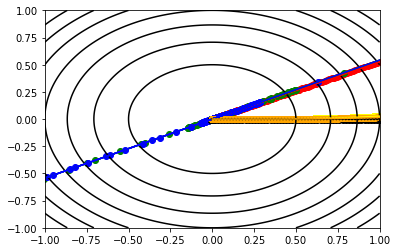

In [103]:
draw_circles(all_points, J, size=1)

In [104]:
from mpl_toolkits.mplot3d import Axes3D
def draw_plot_surface(J):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    Z = J(X, Y)
    return ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)

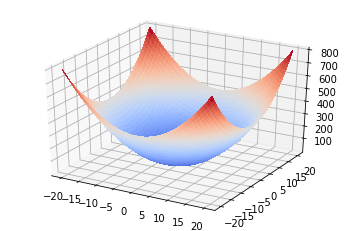

In [105]:
draw_plot_surface(J)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [109]:
def J(x, y):
    if isinstance(x, np.ndarray) or isinstance(x, float):
        return x**2 * np.sin(x) + y**2 * np.sin(y)
    else:
        return x**2 * x.sin() + y**2 * y.sin()

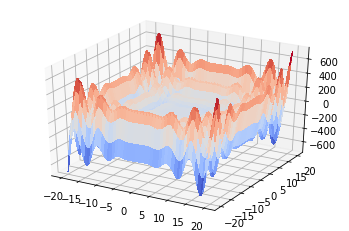

In [110]:
draw_plot_surface(J)

In [111]:
all_points = use_optimizers(J, max_iter=3000)

Starting point (-9.568779623758628, -1.8748816074235064)

Minimum for GD : -67.5802835768388 , num_iterations = 3001
Minimum for Momentum : -67.5802835768388 , num_iterations = 3001
Minimum for NAG : -67.5802835768388 , num_iterations = 3001
Minimum for Adagrad : -56.83952646744492 , num_iterations = 3001
Minimum for Adadelta : -67.57951942552374 , num_iterations = 3001
Minimum for Adam : -67.58028357683878 , num_iterations = 3001


red - GD
green - Momentum
blue - NAG
yellow - Adagrad
black - Adadelta
orange - Adam


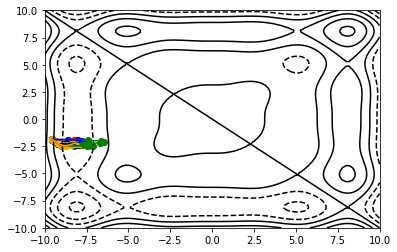

In [123]:
draw_circles(all_points, J, size=10)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [0]:
def J(x, y):
    if isinstance(x, np.ndarray) or isinstance(x, float):
        return x**2 * np.sin(x**2) + y**2 * np.sin(y**2)
    else:
        return x**2 * ((x**2).sin()) + y**2 * ((y**2).sin())

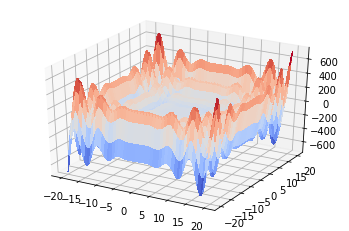

In [124]:
draw_plot_surface(J)

In [125]:
all_points = use_optimizers(J, max_iter=3000)

Starting point (-4.512776019298618, -2.4933539601249888)

Minimum for GD : -7.890603250568652 , num_iterations = 3001
Minimum for Momentum : -7.8906032505686525 , num_iterations = 3001
Minimum for NAG : -7.8906032505686525 , num_iterations = 3001
Minimum for Adagrad : -0.5742278155002096 , num_iterations = 3001
Minimum for Adadelta : -7.890487743093521 , num_iterations = 3001
Minimum for Adam : -7.890603250568652 , num_iterations = 3001


red - GD
green - Momentum
blue - NAG
yellow - Adagrad
black - Adadelta
orange - Adam


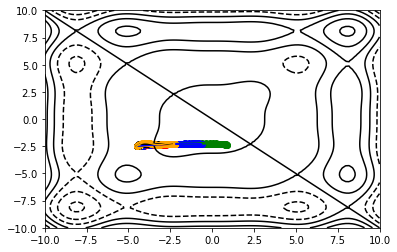

In [128]:
draw_circles(all_points, J, size=10)

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [135]:
optimizers = ['Adam', 'Adagrad', 'AdaDelta', 'SGD']

In [146]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [150]:
from IPython.display import clear_output
def train(network, epochs, learning_rate, optimizer):
    loss = nn.NLLLoss()
    if optimizer == 'Adam':
        optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    elif optimizer == 'Adagrad':
        optimizer = torch.optim.Adagrad(network.parameters(), lr=learning_rate)
    elif optimizer == 'AdaDelta':
        optimizer = torch.optim.Adadelta(network.parameters(), lr=learning_rate)
    elif optimizer == 'SGD':
        optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)
    else:
        raise 1
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

In [161]:
import torch
from torch import nn
from torch.autograd import Variable

class FullyConnectedClassifier(nn.Module):
    def __init__(self, image_size):
        super(FullyConnectedClassifier, self).__init__()
        self.linear_input = nn.Sequential(nn.Linear(image_size*image_size, 200), nn.ReLU())
        self.linear_hidden = nn.Sequential(nn.Linear(200, 200), nn.ReLU())
        self.linear_output = nn.Sequential(nn.Linear(200, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_input(x)
        x = self.linear_hidden(x)
        x = self.linear_output(x)
        return x

Epoch 9... (Train/Test) NLL: 0.029/0.101	Accuracy: 0.992/0.977


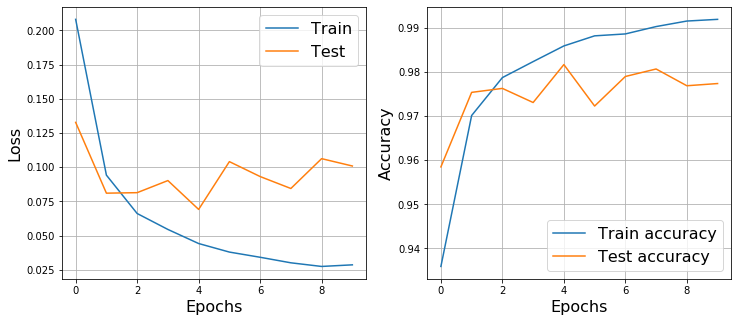

In [162]:
net = FullyConnectedClassifier(28)

train(net, 10, 0.001, 'Adam')

Epoch 9... (Train/Test) NLL: 0.177/0.176	Accuracy: 0.950/0.947


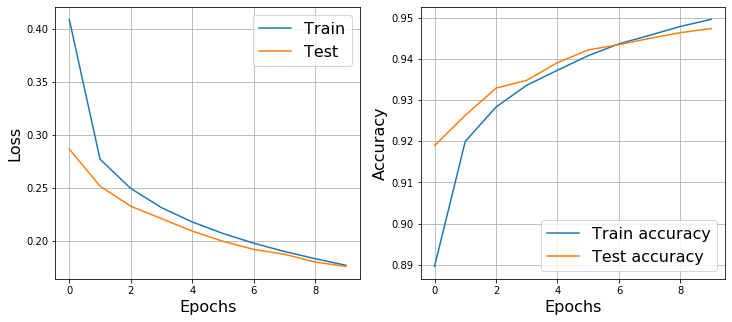

In [163]:
net = FullyConnectedClassifier(28)

train(net, 10, 0.001, 'Adagrad')

Epoch 9... (Train/Test) NLL: 0.416/0.388	Accuracy: 0.889/0.897


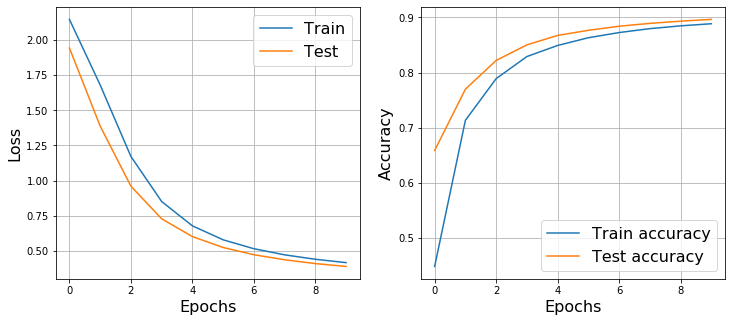

In [164]:
net = FullyConnectedClassifier(28)

train(net, 10, 0.001, 'AdaDelta')

Epoch 9... (Train/Test) NLL: 0.272/0.256	Accuracy: 0.921/0.927


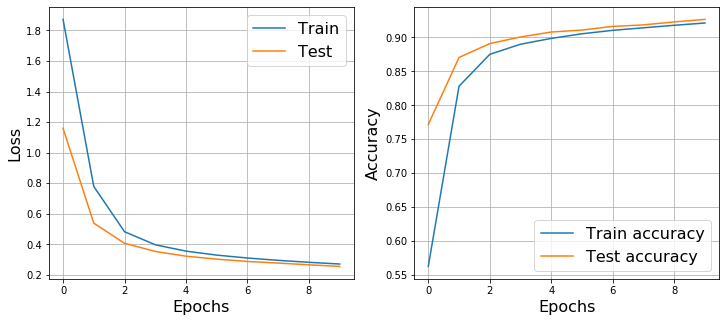

In [165]:
net = FullyConnectedClassifier(28)

train(net, 10, 0.001, 'SGD')

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [166]:
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*3, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 9... (Train/Test) NLL: 0.108/0.111	Accuracy: 0.967/0.966


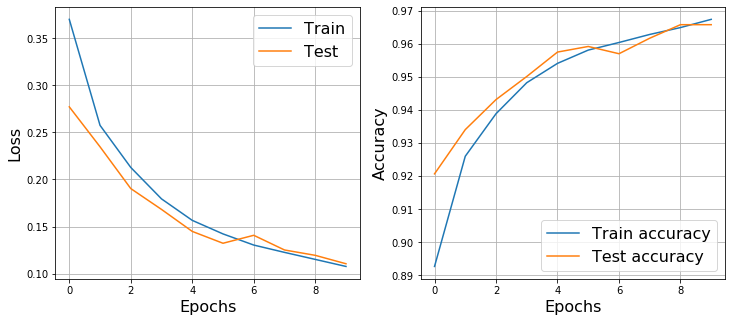

In [167]:
net = ConvClassifier(28)

train(net, 10, 0.001, 'Adam')

Epoch 9... (Train/Test) NLL: 0.359/0.341	Accuracy: 0.897/0.903


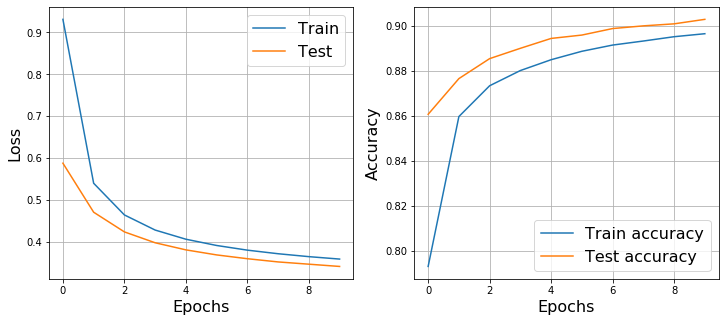

In [168]:
net = ConvClassifier(28)

train(net, 10, 0.001, 'Adagrad')

Epoch 9... (Train/Test) NLL: 0.658/0.608	Accuracy: 0.831/0.848


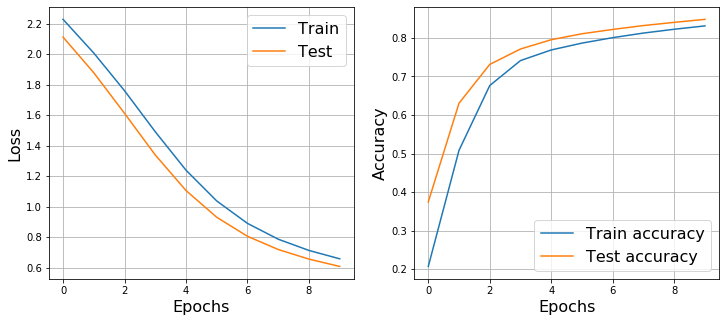

In [169]:
net = ConvClassifier(28)

train(net, 10, 0.001, 'AdaDelta')

Epoch 9... (Train/Test) NLL: 0.288/0.271	Accuracy: 0.918/0.924


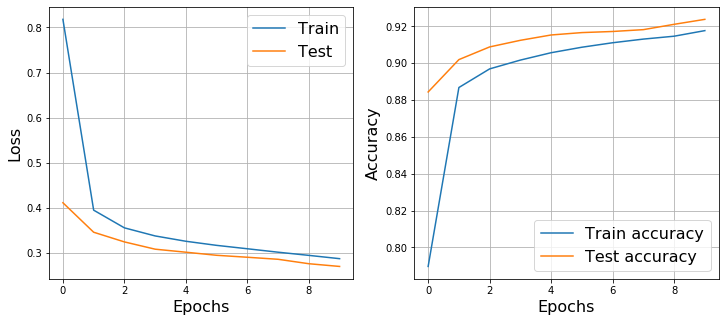

In [170]:
net = ConvClassifier(28)

train(net, 10, 0.001, 'SGD')

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Type Markdown and LaTeX:  𝛼2

Здесь вы можете оставить комментарии по лекции или семинару: